In [12]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [30]:
def get_corners_of_images_with_match(first_img, second_img, pattern_size_cartesian):
    # find the max pattern size for both images
    first_img_max_pattern, second_img_max_pattern = None, None
    first_img_corners, second_img_corners = None, None
    for pattern_size in pattern_size_cartesian:
        first_ret, first_corners = cv2.findChessboardCorners(first_img, pattern_size, None)
        second_ret, second_corners = cv2.findChessboardCorners(second_img, pattern_size, None)
        if first_ret:
            first_img_max_pattern = pattern_size
            first_img_corners = first_corners

        if second_ret:
            second_img_max_pattern = pattern_size
            second_img_corners = second_corners
    return first_img_max_pattern, first_img_corners, second_img_max_pattern, second_img_corners

def plot_found_corners(first_img, first_img_max_pattern, first_img_corners, second_img, second_img_max_pattern, second_img_corners):
    first_rgb = cv2.cvtColor(first_img, cv2.COLOR_GRAY2RGB)
    first_rgb = cv2.drawChessboardCorners(first_rgb, first_img_max_pattern, first_img_corners, True)
    plt.figure(figsize=(5, 5))
    plt.imshow(first_rgb)

    second_rgb = cv2.cvtColor(second_img, cv2.COLOR_GRAY2RGB)
    second_rgb = cv2.drawChessboardCorners(second_rgb, second_img_max_pattern, second_img_corners, True)
    plt.figure(figsize=(5, 5))
    plt.imshow(second_rgb)

def get_homography():
    pass

def homography_estimation():
    pass

In [3]:
cartesian = []
for col in range(10, 15):
    for row in range(10, 15):
        cartesian.append((col, row))

In [4]:
first_path = os.path.join('.', 'Checkerboard Images', 'Image1.tif')
second_path = os.path.join('.', 'Checkerboard Images', 'Image9.tif')
first_img_data = cv2.imread(first_path, cv2.IMREAD_GRAYSCALE)
second_img_data = cv2.imread(second_path, cv2.IMREAD_GRAYSCALE)
first_pattern, first_corner, second_pattern, second_corner = get_corners_of_images_with_match(first_img_data, second_img_data, cartesian)

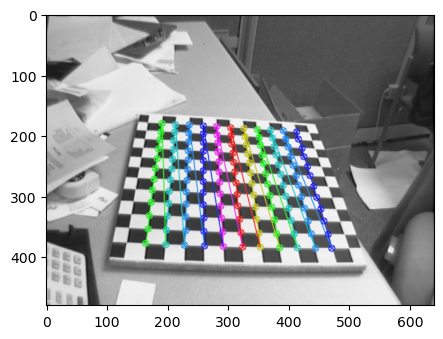

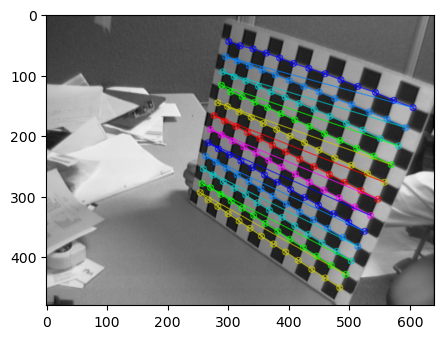

In [31]:
plot_found_corners(first_img_data, first_pattern, first_corner, second_img_data, second_pattern, second_corner)

In [42]:
second_pattern

(13, 12)

In [41]:
# based on the resulting plots there should be some corrections between corners for them to match
# remove unnecessary dimension
first_corner = first_corner.squeeze()
second_corner = second_corner.squeeze()

# split them into groups
first_corner = np.split(first_corner, list(first_pattern)[0])
second_corner

array([[412.95126, 194.31284],
       [415.73883, 206.39171],
       [421.5109 , 220.9861 ],
       [424.84415, 234.66666],
       [430.762  , 250.56642],
       [434.64294, 265.84293],
       [441.11053, 283.78635],
       [445.93607, 301.58994],
       [452.63834, 321.14746],
       [457.79102, 341.03537],
       [465.37445, 362.78656],
       [470.7925 , 385.52097],
       [390.6848 , 191.71242],
       [395.2899 , 205.81723],
       [398.66956, 219.25528],
       [403.224  , 233.97516],
       [407.17795, 249.44   ],
       [411.72894, 265.6789 ],
       [415.511  , 281.86716],
       [421.49454, 300.99   ],
       [425.50647, 319.6926 ],
       [432.08038, 340.79532],
       [436.5287 , 361.85544],
       [443.7908 , 385.83313],
       [370.32382, 190.9713 ],
       [373.16345, 204.33011],
       [376.33118, 218.12924],
       [379.44547, 232.34659],
       [383.40555, 247.97725],
       [386.54205, 263.94415],
       [391.10147, 281.7222 ],
       [394.51468, 299.63586],
       [